# Model Training


## Introduction: what is VGG?

VGG, proposed by [Simonyan and Zisserman in 2014](https://arxiv.org/abs/1409.1556), is another influential deep convolutional neural network architecture known for its simplicity and effectiveness. It consists of a series of convolutional layers followed by max-pooling layers, with increasing depth as the network progresses.

The key characteristic of VGG is its uniform architecture, where the convolutional layers have a small receptive field (3x3 kernel size) and are stacked one after the other, followed by max-pooling layers for downsampling. This straightforward design, with its repeated blocks of convolutional layers, allows VGG to learn hierarchical features effectively. Although VGG is not as computationally efficient as some later architectures, it served as a crucial milestone in the evolution of deep learning models for image classification. VGG is available in several variants, such as VGG-16 and VGG-19, which differ in the number of layers. In this tutorial, we will use the VGG-19 variant.

## Setup and data loading

In [2]:
# Import numpy, matplotlib, seaborn, and other necessary libraries
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# Import keras and its modules
import keras_cv

import keras
from keras import layers
from keras.applications import VGG19
from keras import optimizers
from keras import losses
from keras import metrics

# Set the seeds for reproducibility
SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

Using TensorFlow backend


### Define Hyperparameters

First, let's define the hyperparameters. We will use a batch size of 32 and train for 10 epochs. We will use the RMSProp optimizer with a learning rate of 0.001. The image size is set to 224x224.

In [3]:
# Set the batch size, image size, and number of epochs
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 10
lr = 1e-4

### Gather Malaria Dataset

Here we load data from [tensorflow_datasets](https://www.tensorflow.org/datasets). Malaria dataset is provided in TFDS as [malaria](https://www.tensorflow.org/datasets/catalog/malaria). It features 27,558 images that belong to 2 classes: parasitized and uninfected.

In [4]:
# Set the dataset name
dataset_name = "malaria"

# Load the dataset and split it into train and test sets
(train_ds, test_ds), ds_info = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:]"],
    with_info=True,
    as_supervised=True,
)

# Get the number of classes in the dataset
NUM_CLASSES = ds_info.features["label"].num_classes


def package_inputs(image, label):
    """
    Packages the input image and label into a dictionary.

    Args:
        image: The input image.
        label: The corresponding label.

    Returns:
        A dictionary containing the input image and label.
    """
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


# Map the `package_inputs` function to the train and test sets
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the training dataset
train_ds = train_ds.shuffle(BATCH_SIZE * 16)

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Visualise the dataset

The following code shows the images from the training set.

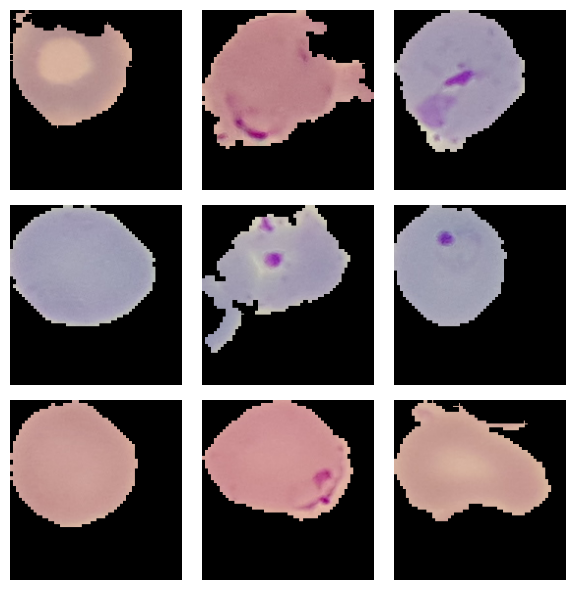

In [5]:
# Applying raggad batching to the train and test sets
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

# Image batch for visualization from the train set
batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

### Data Augmentation

We can use the keras cv layers to perform data augmentation. In this notebook, we apply various augmentation techniques such as random flipping, rotation, translation, and contrast/brightness adjustment to the input images. These techniques help in increasing the diversity of the training data and improve the model's ability to generalize to unseen examples.

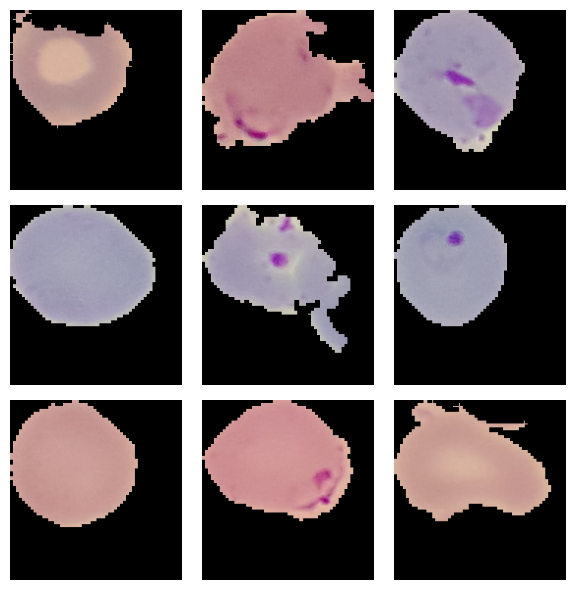

In [6]:
# Randomly flip the images in the batch
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

# Apply the augmenters to the image batch
image_batch = random_flip(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

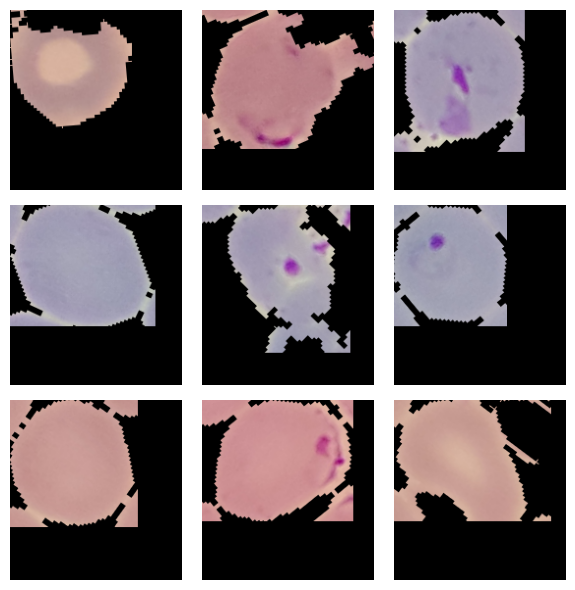

In [7]:
# Randomly rotate the images in the batch
random_rotation = keras_cv.layers.RandomRotation(factor=0.15)
augmenters = [random_rotation]

# Apply the augmenters to the image batch
image_batch = random_rotation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

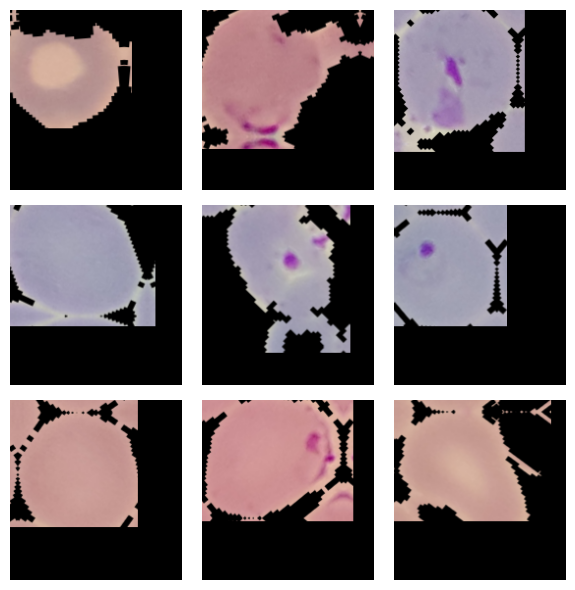

In [8]:
# Randomly translate the images in the batch
random_translation = keras_cv.layers.RandomTranslation(
    height_factor=0.1, width_factor=0.1
)
augmenters = [random_translation]

# Apply the augmenters to the image batch
image_batch = random_translation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

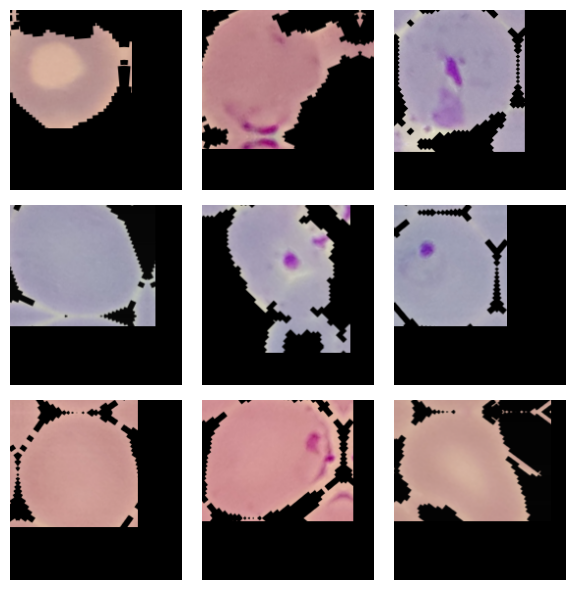

In [9]:
# Randomly change contrast of the images in the batch
random_contrast = keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255))
augmenters = [random_contrast]

# Apply the augmenters to the image batch
image_batch = random_contrast(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [10]:
def create_augmenter_fn(augmenters):
    """
    Creates an augmenter function that applies a list of augmenters to the inputs.

    Args:
        augmenters (list): List of augmenter functions to be applied.

    Returns:
        augmenter_fn (function): Augmenter function that applies the augmenters to the inputs.
    """

    def augmenter_fn(inputs):
        """
        Apply a series of augmentations to the input data.

        Args:
            inputs: The input data to be augmented.

        Returns:
            The augmented data.
        """
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


# Apply all the previously defined augmenters to the train set
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

### Prepare Inputs

Once we verify the input data and augmentation are working correctly, we prepare the dataset for training. The input data is resized to a uniform size of 224x224.


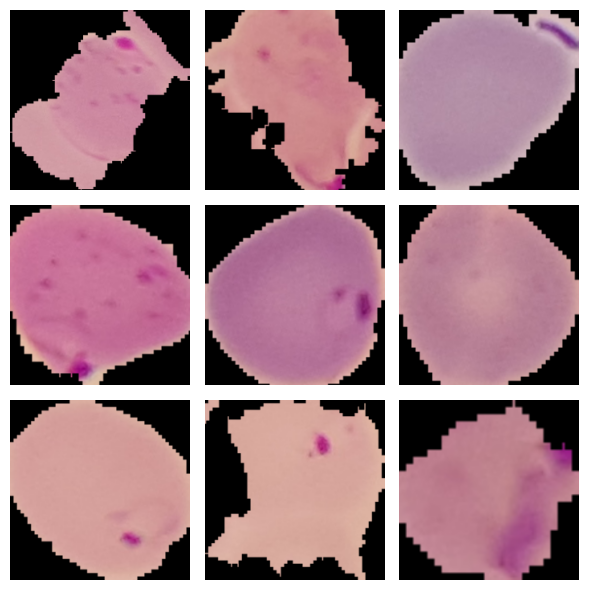

In [11]:
# Resizing the images in the train and test sets
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)
train_ds = train_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize the images in the batch
image_batch = next(iter(eval_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [12]:
def unpackage_dict(inputs):
    """
    Unpackages a dictionary and returns the values of the 'images' and 'labels' keys.

    Parameters:
    inputs (dict): A dictionary containing the 'images' and 'labels' keys.

    Returns:
    tuple: A tuple containing the values of the 'images' and 'labels' keys.
    """
    return inputs["images"], inputs["labels"]


# Unpackage the dictionaries in the train and test sets
train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

## Define Optimizer and Loss

In this section, we define the optimizer and loss function for our model training.

We use the RMSProp optimizer with a learning rate of 1e-4. This optimizer is known for its ability to handle non-stationary objectives and adapt to changing conditions during training. The loss function we use is binary cross entropy. This loss function is commonly used for binary classification problems, where each sample belongs to one of two classes.

By defining the optimizer and loss function, we set the foundation for our model training process and ensure that the model is optimized to minimize the loss and improve its performance.

In [13]:
# Optimizer function for the model
optimizer_fn = optimizers.RMSprop(learning_rate=lr)

# Loss function for the model
loss_fn = losses.BinaryCrossentropy(label_smoothing=0.1)

## Set up Callbacks

We use callbacks to enhance the training process and monitor the model's performance. Here are the callbacks we use in this notebook:

- ModelCheckpoint: This callback saves the model weights after each epoch if the validation accuracy improves. It helps us keep track of the best model during training.

- EarlyStopping: This callback monitors the validation loss and stops the training if the loss does not improve after a certain number of epochs. It helps us prevent overfitting and saves training time.

- ReduceLROnPlateau: This callback reduces the learning rate when the validation loss plateaus. It helps us fine-tune the model and improve its performance.

- TensorBoard: This callback logs the training and validation loss to TensorBoard, which allows us to visualize and analyze the training process.

By using these callbacks, we can optimize the training process and improve the performance of our model.

In [14]:
# Callbacks for the training process
train_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3),
    keras.callbacks.TensorBoard(log_dir="./logs"),
]

## Transfer Learning from Pre-trained Weights

We use transfer learning to initialize the model weights with pre-trained weights. By using pre-trained weights, we can leverage the knowledge gained from training on a large dataset to solve our own problem. This allows us to train a model with less data and less time, while still being able to achieve good performance.

In [15]:
def build_model(num_classes):
    """
    Build a model for malaria diagnosis using VGG19.

    Args:
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled model.

    """
    # Create the base model from the pre-trained model VGG19
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = VGG19(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top of pretrained model
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="VGG19")
    optimizer = optimizer_fn
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
    return model

In [16]:
# Model summary
model = build_model(NUM_CLASSES)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

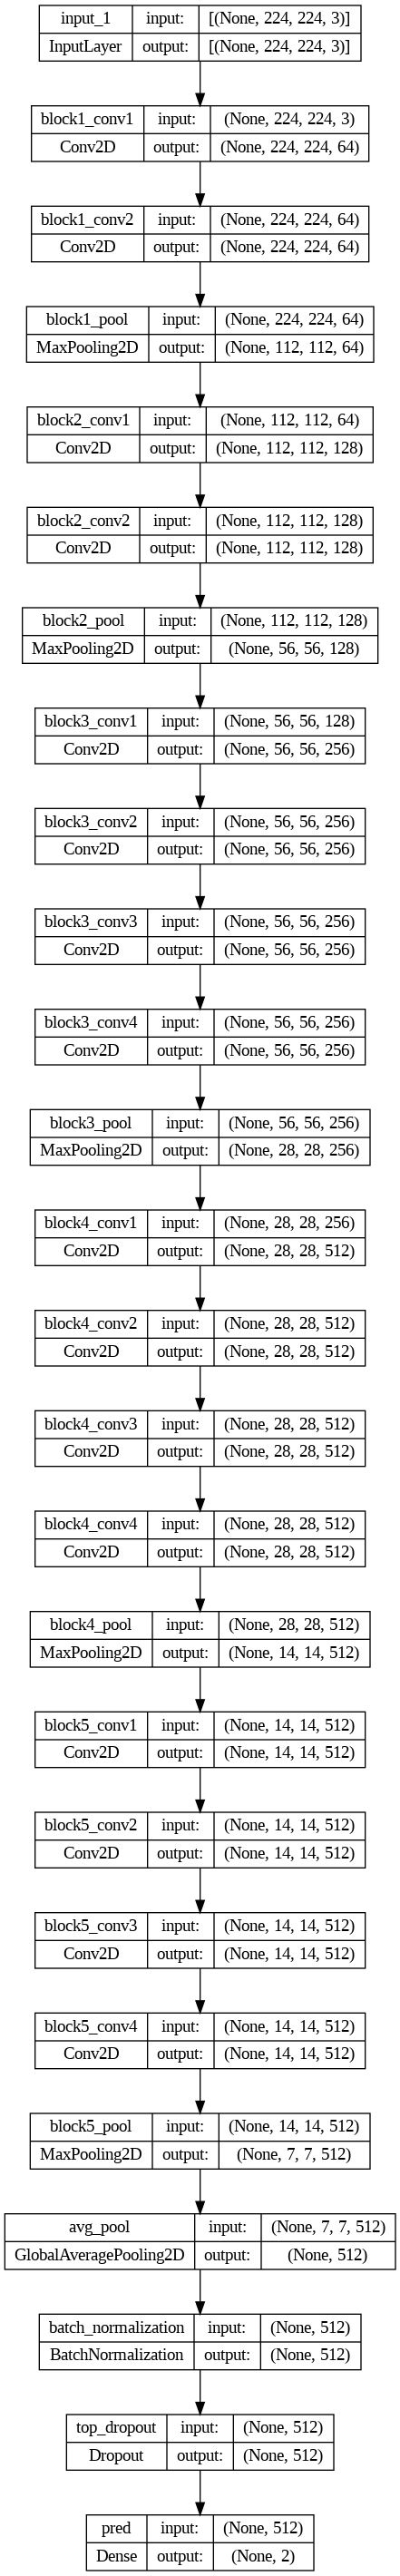

In [17]:
# Model plot
keras.utils.plot_model(
    model,
    to_file="vgg_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
)

### Train the Model

In [18]:
# Model training
history = model.fit(
    train_ds, epochs=EPOCHS, callbacks=train_callbacks, validation_data=eval_ds
)

Epoch 1/10
689/689 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7952

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 157s 210ms/step - loss: 0.5655 - accuracy: 0.7952 - val_loss: 0.4041 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 2/10
689/689 [==============================] - 137s 199ms/step - loss: 0.4099 - accuracy: 0.8984 - val_loss: 0.3611 - val_accuracy: 0.9242 - lr: 1.0000e-04
Epoch 3/10
689/689 [==============================] - 137s 199ms/step - loss: 0.3837 - accuracy: 0.9127 - val_loss: 0.3454 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 4/10
689/689 [==============================] - 152s 220ms/step - loss: 0.3676 - accuracy: 0.9197 - val_loss: 0.3372 - val_accuracy: 0.9334 - lr: 1.0000e-04
Epoch 5/10
689/689 [==============================] - 151s 219ms/step - loss: 0.3618 - accuracy: 0.9228 - val_loss: 0.3320 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 6/10
689/689 [==============================] - 151s 219ms/step - loss: 0.3537 - accuracy: 0.9279 - val_loss: 0.3284 - val_accuracy: 0.9378 - lr: 1.0000e-04
Epoch 7/10
689/689 [=============

### Plot the Training and Validation Metrics

Plot the training and validation accuracy/loss curves of the model. We can use these plots to check if the model has overfitted or underfitted the training data.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


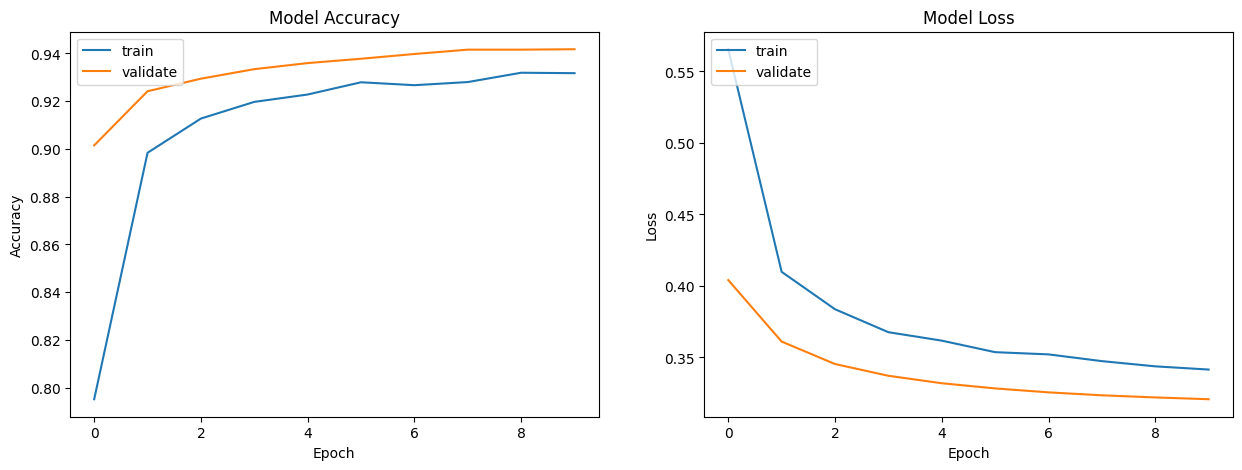

In [19]:
def plotmodelhistory(history):
    """
    Plots the model accuracy and loss for the training and validation sets.

    Parameters:
    history (keras.callbacks.History): The history object returned by the model.fit() function.

    Returns:
    None
    """

    # Plotting the model accuracy and loss for the training and validation sets
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # summarize history for accuracy
    axs[0].plot(history.history["accuracy"])
    axs[0].plot(history.history["val_accuracy"])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(["train", "validate"], loc="upper left")

    # summarize history for loss
    axs[1].plot(history.history["loss"])
    axs[1].plot(history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(["train", "validate"], loc="upper left")
    plt.show()


# list all data in history
print(history.history.keys())

plotmodelhistory(history)

### Evaluate the Model

In [20]:
# Evaluate the model on the test set
accuracy = model.evaluate(eval_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

173/173 [==============================] - 27s 156ms/step - loss: 0.3208 - accuracy: 0.9418
Accuracy: 94.18%


## Conclusion

- Model accuracy of VGG19 in the training set is 93.17% and in the validation set is 94.18%.